In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', "sonar.all-data.csv")

sys.path.append(api_path)
sys.path.append(api_path_ml_est)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

In [22]:
df = pd.read_csv(api_path_data, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [31]:
inputs_df.shape

(208, 60)

In [176]:
inputs_df = df.drop(60, axis=1)
inputs_df['60'] = np.ones(inputs_df.shape[0])
targets_df = pd.get_dummies(df[60], dtype = np.int32)
inputs_df = torch.FloatTensor(inputs_df.to_numpy())
mine_y_df = torch.FloatTensor((targets_df['M'] * 2 - 1).to_numpy())


X_train, X_test, y_train, y_test = train_test_split(inputs_df, 
                                                    mine_y_df, 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train_small = X_train[:, :-1]
X_test_small = X_test[:, :-1]

In [325]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        
    
    def func(self, w, X, y):
        """
        Get loss function value for data X, target y and coefficient w.

        Parameters
        ----------
        X : scipy.sparse.csr_matrix or numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        exp_part = y[:, None] * (X @ w.T)
        batch_sigmoid = torch.logaddexp(torch.zeros_like(exp_part), -exp_part) #np.logaddexp(0., -exp_part) 
        return batch_sigmoid.sum(axis = 0) + self.l2_coef*(torch.norm(w[:, :-1], dim = 1)**2)
    
    def log_prob_args(self, w, X, y):
        return -self.func(w, X, y)

In [326]:
def compute_sir_log_weights(x, target, proposal):
    return target.log_prob(x) -  proposal.log_prob(x)

def sir_correlated_dynamics_logreg(z, target, proposal, n_steps, N, alpha,
                                   X_train, X_test,
                                   y_train, y_test):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    loss_train = []
    loss_test = []
    
    for _ in range(n_steps):
        z_sp.append(z)
        z_copy = z.unsqueeze(1).repeat(1, N, 1)
        ind = torch.randint(0, N, (batch_size,)).tolist()
        W = proposal.sample([batch_size, N])
        U = proposal.sample([batch_size]).unsqueeze(1).repeat(1, N, 1)
        #print(W.shape, U.shape, z_copy.shape)
        X = torch.zeros((batch_size, N, z_dim), dtype = z.dtype).to(z.device)
        X =  (alpha**2)*z_copy + alpha*((1- alpha**2)**0.5)*U + W*((1- alpha**2)**0.5)
        X[np.arange(batch_size), ind, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]        

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        train_loss = target.func(z, X_train, y_train).item()
        test_loss = target.func(z, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))
        
    z_sp.append(z)
    return z_sp, loss_train, loss_test

In [327]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42,
                         tol=1e-7,
                         max_iter = 1000,
                         C = 1.).fit(X_train_small, y_train)

In [328]:
w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))

In [329]:
train_loss_clf = target.func(w_clf, X_train, y_train).item()
test_loss_clf = target.func(w_clf, X_test, y_test).item()
print(train_loss, test_loss)

180.54745483398438 88.87361907958984


In [330]:
clf.score(X_train_small, y_train)

0.8551724137931035

In [331]:
clf.score(X_test_small, y_test)

0.8095238095238095

In [282]:
zeros_start = torch.zeros((1, dim))
train_loss = target.func(zeros_start, X_train, y_train).item()
test_loss = target.func(zeros_start, X_test, y_test).item()
print(train_loss, test_loss)

100.50634002685547 43.66827392578125


In [362]:
device = 'cpu'
scale_proposal = 1.0
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)

n_steps = 10000
batch_size = 1
c = 1
N = 10
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
start = torch.zeros((1, dim))
history, loss_train, loss_test = sir_correlated_dynamics_logreg(start, 
                                                                target,
                                                                proposal, 
                                                                n_steps, 
                                                                N, 
                                                                alpha,
                                                                X_train, X_test,
                                                                y_train, y_test)

Iter: 0, Training loss: 100.506340, Test loss 43.668274
Iter: 1, Training loss: 100.506340, Test loss 43.668274
Iter: 2, Training loss: 100.506340, Test loss 43.668274
Iter: 3, Training loss: 99.613747, Test loss 42.565704
Iter: 4, Training loss: 99.613747, Test loss 42.565704
Iter: 5, Training loss: 100.520523, Test loss 43.224380
Iter: 6, Training loss: 95.668083, Test loss 41.075943
Iter: 7, Training loss: 95.668083, Test loss 41.075943
Iter: 8, Training loss: 94.436531, Test loss 42.049667
Iter: 9, Training loss: 96.145515, Test loss 43.991882
Iter: 10, Training loss: 94.958733, Test loss 44.168636
Iter: 11, Training loss: 94.958733, Test loss 44.168636
Iter: 12, Training loss: 94.958733, Test loss 44.168636
Iter: 13, Training loss: 95.643883, Test loss 45.216846
Iter: 14, Training loss: 95.666328, Test loss 44.739555
Iter: 15, Training loss: 95.666328, Test loss 44.739555
Iter: 16, Training loss: 96.663635, Test loss 46.318943
Iter: 17, Training loss: 96.663635, Test loss 46.31894

Iter: 246, Training loss: 103.814728, Test loss 60.909176
Iter: 247, Training loss: 103.814728, Test loss 60.909176
Iter: 248, Training loss: 103.814728, Test loss 60.909176
Iter: 249, Training loss: 103.600716, Test loss 60.639446
Iter: 250, Training loss: 100.567635, Test loss 60.541718
Iter: 251, Training loss: 101.353363, Test loss 60.774818
Iter: 252, Training loss: 101.353363, Test loss 60.774818
Iter: 253, Training loss: 102.287796, Test loss 60.829102
Iter: 254, Training loss: 100.105637, Test loss 59.079201
Iter: 255, Training loss: 98.313934, Test loss 58.334862
Iter: 256, Training loss: 98.313934, Test loss 58.334862
Iter: 257, Training loss: 98.313934, Test loss 58.334862
Iter: 258, Training loss: 98.313934, Test loss 58.334862
Iter: 259, Training loss: 98.770798, Test loss 59.207767
Iter: 260, Training loss: 98.770798, Test loss 59.207767
Iter: 261, Training loss: 97.903542, Test loss 57.480186
Iter: 262, Training loss: 97.903542, Test loss 57.480186
Iter: 263, Training lo

Iter: 485, Training loss: 106.798203, Test loss 70.378433
Iter: 486, Training loss: 106.798203, Test loss 70.378433
Iter: 487, Training loss: 103.560074, Test loss 67.440147
Iter: 488, Training loss: 103.560074, Test loss 67.440147
Iter: 489, Training loss: 103.531639, Test loss 67.976654
Iter: 490, Training loss: 103.531639, Test loss 67.976654
Iter: 491, Training loss: 104.327103, Test loss 68.858505
Iter: 492, Training loss: 102.131607, Test loss 67.697380
Iter: 493, Training loss: 102.131607, Test loss 67.697380
Iter: 494, Training loss: 102.280060, Test loss 67.398254
Iter: 495, Training loss: 104.198502, Test loss 69.541763
Iter: 496, Training loss: 104.676315, Test loss 67.864838
Iter: 497, Training loss: 104.676315, Test loss 67.864838
Iter: 498, Training loss: 100.464714, Test loss 62.448334
Iter: 499, Training loss: 100.464714, Test loss 62.448334
Iter: 500, Training loss: 101.239601, Test loss 61.182400
Iter: 501, Training loss: 101.239601, Test loss 61.182400
Iter: 502, Tra

Iter: 748, Training loss: 102.807060, Test loss 60.854446
Iter: 749, Training loss: 101.448105, Test loss 58.312176
Iter: 750, Training loss: 103.372162, Test loss 61.250160
Iter: 751, Training loss: 103.755402, Test loss 61.010788
Iter: 752, Training loss: 103.755402, Test loss 61.010788
Iter: 753, Training loss: 103.755402, Test loss 61.010788
Iter: 754, Training loss: 106.554413, Test loss 62.865604
Iter: 755, Training loss: 106.554413, Test loss 62.865604
Iter: 756, Training loss: 106.554413, Test loss 62.865604
Iter: 757, Training loss: 105.080994, Test loss 63.027424
Iter: 758, Training loss: 105.080994, Test loss 63.027424
Iter: 759, Training loss: 107.261780, Test loss 63.592434
Iter: 760, Training loss: 105.241066, Test loss 61.856033
Iter: 761, Training loss: 106.350281, Test loss 62.738510
Iter: 762, Training loss: 108.633240, Test loss 62.898632
Iter: 763, Training loss: 108.633240, Test loss 62.898632
Iter: 764, Training loss: 108.633240, Test loss 62.898632
Iter: 765, Tra

Iter: 1004, Training loss: 107.544846, Test loss 67.190842
Iter: 1005, Training loss: 105.557037, Test loss 66.111855
Iter: 1006, Training loss: 105.422089, Test loss 65.470192
Iter: 1007, Training loss: 103.938934, Test loss 62.273277
Iter: 1008, Training loss: 104.295502, Test loss 64.308212
Iter: 1009, Training loss: 104.295502, Test loss 64.308212
Iter: 1010, Training loss: 104.295502, Test loss 64.308212
Iter: 1011, Training loss: 104.295502, Test loss 64.308212
Iter: 1012, Training loss: 105.062378, Test loss 65.242004
Iter: 1013, Training loss: 105.062378, Test loss 65.242004
Iter: 1014, Training loss: 106.346207, Test loss 66.829887
Iter: 1015, Training loss: 106.346207, Test loss 66.829887
Iter: 1016, Training loss: 106.346207, Test loss 66.829887
Iter: 1017, Training loss: 106.346207, Test loss 66.829887
Iter: 1018, Training loss: 106.346207, Test loss 66.829887
Iter: 1019, Training loss: 106.116684, Test loss 67.412239
Iter: 1020, Training loss: 106.116684, Test loss 67.4122

Iter: 1255, Training loss: 95.792061, Test loss 55.107559
Iter: 1256, Training loss: 95.792061, Test loss 55.107559
Iter: 1257, Training loss: 98.091316, Test loss 56.685108
Iter: 1258, Training loss: 98.091316, Test loss 56.685108
Iter: 1259, Training loss: 95.577911, Test loss 53.914848
Iter: 1260, Training loss: 95.577911, Test loss 53.914848
Iter: 1261, Training loss: 95.858124, Test loss 54.666660
Iter: 1262, Training loss: 95.858124, Test loss 54.666660
Iter: 1263, Training loss: 95.858124, Test loss 54.666660
Iter: 1264, Training loss: 95.858124, Test loss 54.666660
Iter: 1265, Training loss: 94.992882, Test loss 53.934731
Iter: 1266, Training loss: 94.992882, Test loss 53.934731
Iter: 1267, Training loss: 96.220230, Test loss 55.545460
Iter: 1268, Training loss: 98.475861, Test loss 57.457413
Iter: 1269, Training loss: 98.748260, Test loss 57.590061
Iter: 1270, Training loss: 98.748260, Test loss 57.590061
Iter: 1271, Training loss: 97.596230, Test loss 56.236053
Iter: 1272, Tr

Iter: 1506, Training loss: 104.344048, Test loss 65.316582
Iter: 1507, Training loss: 104.344048, Test loss 65.316582
Iter: 1508, Training loss: 104.344048, Test loss 65.316582
Iter: 1509, Training loss: 107.373825, Test loss 67.072510
Iter: 1510, Training loss: 103.156891, Test loss 63.157768
Iter: 1511, Training loss: 103.156891, Test loss 63.157768
Iter: 1512, Training loss: 103.156891, Test loss 63.157768
Iter: 1513, Training loss: 103.220215, Test loss 62.392754
Iter: 1514, Training loss: 105.327995, Test loss 64.312454
Iter: 1515, Training loss: 105.327995, Test loss 64.312454
Iter: 1516, Training loss: 103.622459, Test loss 63.313469
Iter: 1517, Training loss: 105.592453, Test loss 66.773102
Iter: 1518, Training loss: 104.556786, Test loss 64.452850
Iter: 1519, Training loss: 105.454498, Test loss 64.487152
Iter: 1520, Training loss: 105.454498, Test loss 64.487152
Iter: 1521, Training loss: 105.454498, Test loss 64.487152
Iter: 1522, Training loss: 105.755127, Test loss 64.9195

Iter: 1768, Training loss: 109.212067, Test loss 69.623932
Iter: 1769, Training loss: 105.602966, Test loss 66.586105
Iter: 1770, Training loss: 106.837311, Test loss 66.206055
Iter: 1771, Training loss: 105.406937, Test loss 68.940872
Iter: 1772, Training loss: 105.707855, Test loss 69.339729
Iter: 1773, Training loss: 106.886963, Test loss 69.331886
Iter: 1774, Training loss: 106.886963, Test loss 69.331886
Iter: 1775, Training loss: 105.181999, Test loss 67.909096
Iter: 1776, Training loss: 105.181999, Test loss 67.909096
Iter: 1777, Training loss: 104.891380, Test loss 67.841232
Iter: 1778, Training loss: 104.967133, Test loss 67.617584
Iter: 1779, Training loss: 105.825302, Test loss 68.486755
Iter: 1780, Training loss: 105.825302, Test loss 68.486755
Iter: 1781, Training loss: 106.464584, Test loss 69.448997
Iter: 1782, Training loss: 110.082169, Test loss 73.304436
Iter: 1783, Training loss: 110.082169, Test loss 73.304436
Iter: 1784, Training loss: 109.771301, Test loss 72.0778

Iter: 2020, Training loss: 115.817719, Test loss 77.608498
Iter: 2021, Training loss: 114.881111, Test loss 76.710045
Iter: 2022, Training loss: 113.436562, Test loss 75.905716
Iter: 2023, Training loss: 114.092606, Test loss 75.696358
Iter: 2024, Training loss: 114.092606, Test loss 75.696358
Iter: 2025, Training loss: 115.922287, Test loss 78.591736
Iter: 2026, Training loss: 117.866684, Test loss 79.845062
Iter: 2027, Training loss: 112.971840, Test loss 76.414169
Iter: 2028, Training loss: 113.682503, Test loss 75.943253
Iter: 2029, Training loss: 113.682503, Test loss 75.943253
Iter: 2030, Training loss: 111.694580, Test loss 74.759781
Iter: 2031, Training loss: 107.854385, Test loss 71.545120
Iter: 2032, Training loss: 106.527596, Test loss 70.610809
Iter: 2033, Training loss: 106.527596, Test loss 70.610809
Iter: 2034, Training loss: 106.427490, Test loss 71.254288
Iter: 2035, Training loss: 110.343765, Test loss 74.008469
Iter: 2036, Training loss: 110.343765, Test loss 74.0084

Iter: 2231, Training loss: 102.895523, Test loss 65.982376
Iter: 2232, Training loss: 101.994476, Test loss 64.378372
Iter: 2233, Training loss: 104.143234, Test loss 65.773529
Iter: 2234, Training loss: 104.056923, Test loss 67.245544
Iter: 2235, Training loss: 104.037079, Test loss 67.509605
Iter: 2236, Training loss: 104.037079, Test loss 67.509605
Iter: 2237, Training loss: 102.746284, Test loss 66.268356
Iter: 2238, Training loss: 102.746284, Test loss 66.268356
Iter: 2239, Training loss: 102.746284, Test loss 66.268356
Iter: 2240, Training loss: 102.746284, Test loss 66.268356
Iter: 2241, Training loss: 105.605347, Test loss 68.323669
Iter: 2242, Training loss: 105.303955, Test loss 67.788689
Iter: 2243, Training loss: 102.695915, Test loss 66.513031
Iter: 2244, Training loss: 98.821152, Test loss 63.217270
Iter: 2245, Training loss: 100.057434, Test loss 62.829460
Iter: 2246, Training loss: 100.608284, Test loss 64.496826
Iter: 2247, Training loss: 103.156212, Test loss 67.48657

Iter: 2413, Training loss: 108.209900, Test loss 72.074791
Iter: 2414, Training loss: 108.209900, Test loss 72.074791
Iter: 2415, Training loss: 108.209900, Test loss 72.074791
Iter: 2416, Training loss: 111.656204, Test loss 74.789688
Iter: 2417, Training loss: 111.656204, Test loss 74.789688
Iter: 2418, Training loss: 107.922485, Test loss 72.055099
Iter: 2419, Training loss: 107.922485, Test loss 72.055099
Iter: 2420, Training loss: 109.963867, Test loss 74.108002
Iter: 2421, Training loss: 109.963867, Test loss 74.108002
Iter: 2422, Training loss: 109.963867, Test loss 74.108002
Iter: 2423, Training loss: 108.702408, Test loss 72.024506
Iter: 2424, Training loss: 109.854095, Test loss 72.855492
Iter: 2425, Training loss: 109.854095, Test loss 72.855492
Iter: 2426, Training loss: 109.854095, Test loss 72.855492
Iter: 2427, Training loss: 109.854095, Test loss 72.855492
Iter: 2428, Training loss: 110.869247, Test loss 74.022392
Iter: 2429, Training loss: 110.560112, Test loss 74.3588

Iter: 2606, Training loss: 103.318214, Test loss 62.108109
Iter: 2607, Training loss: 106.339310, Test loss 65.105621
Iter: 2608, Training loss: 105.479553, Test loss 64.171936
Iter: 2609, Training loss: 106.125992, Test loss 66.798386
Iter: 2610, Training loss: 106.125992, Test loss 66.798386
Iter: 2611, Training loss: 108.169312, Test loss 68.120575
Iter: 2612, Training loss: 107.910065, Test loss 69.408813
Iter: 2613, Training loss: 107.910065, Test loss 69.408813
Iter: 2614, Training loss: 107.910065, Test loss 69.408813
Iter: 2615, Training loss: 108.339966, Test loss 69.204605
Iter: 2616, Training loss: 109.244339, Test loss 69.164474
Iter: 2617, Training loss: 106.136688, Test loss 66.711075
Iter: 2618, Training loss: 103.434158, Test loss 64.772919
Iter: 2619, Training loss: 101.692917, Test loss 62.645763
Iter: 2620, Training loss: 102.138130, Test loss 63.245457
Iter: 2621, Training loss: 101.992767, Test loss 63.417931
Iter: 2622, Training loss: 101.992767, Test loss 63.4179

Iter: 2812, Training loss: 97.235474, Test loss 61.316040
Iter: 2813, Training loss: 97.235474, Test loss 61.316040
Iter: 2814, Training loss: 97.235474, Test loss 61.316040
Iter: 2815, Training loss: 99.223663, Test loss 61.980156
Iter: 2816, Training loss: 99.223663, Test loss 61.980156
Iter: 2817, Training loss: 99.223663, Test loss 61.980156
Iter: 2818, Training loss: 99.223663, Test loss 61.980156
Iter: 2819, Training loss: 97.749756, Test loss 60.307964
Iter: 2820, Training loss: 94.995300, Test loss 57.968777
Iter: 2821, Training loss: 94.995300, Test loss 57.968777
Iter: 2822, Training loss: 94.995300, Test loss 57.968777
Iter: 2823, Training loss: 95.420708, Test loss 58.810020
Iter: 2824, Training loss: 95.420708, Test loss 58.810020
Iter: 2825, Training loss: 95.177788, Test loss 59.954819
Iter: 2826, Training loss: 96.003799, Test loss 58.828217
Iter: 2827, Training loss: 96.257095, Test loss 59.825191
Iter: 2828, Training loss: 97.084625, Test loss 59.710884
Iter: 2829, Tr

Iter: 3043, Training loss: 105.997604, Test loss 66.650368
Iter: 3044, Training loss: 105.997604, Test loss 66.650368
Iter: 3045, Training loss: 104.183220, Test loss 64.890434
Iter: 3046, Training loss: 104.263290, Test loss 65.597275
Iter: 3047, Training loss: 103.686501, Test loss 64.777802
Iter: 3048, Training loss: 103.686501, Test loss 64.777802
Iter: 3049, Training loss: 105.602585, Test loss 64.594582
Iter: 3050, Training loss: 105.602585, Test loss 64.594582
Iter: 3051, Training loss: 104.326759, Test loss 64.418495
Iter: 3052, Training loss: 99.715454, Test loss 60.526554
Iter: 3053, Training loss: 102.985229, Test loss 62.084038
Iter: 3054, Training loss: 99.867004, Test loss 60.004303
Iter: 3055, Training loss: 104.123871, Test loss 62.070984
Iter: 3056, Training loss: 102.871422, Test loss 62.463303
Iter: 3057, Training loss: 101.121918, Test loss 60.873299
Iter: 3058, Training loss: 101.121918, Test loss 60.873299
Iter: 3059, Training loss: 99.911011, Test loss 60.230324


Iter: 3286, Training loss: 108.227966, Test loss 70.717499
Iter: 3287, Training loss: 108.227966, Test loss 70.717499
Iter: 3288, Training loss: 108.414764, Test loss 71.574142
Iter: 3289, Training loss: 106.227219, Test loss 69.532196
Iter: 3290, Training loss: 106.308609, Test loss 68.386177
Iter: 3291, Training loss: 106.308609, Test loss 68.386177
Iter: 3292, Training loss: 106.308609, Test loss 68.386177
Iter: 3293, Training loss: 107.330597, Test loss 69.122284
Iter: 3294, Training loss: 104.568832, Test loss 66.575615
Iter: 3295, Training loss: 106.088654, Test loss 68.244995
Iter: 3296, Training loss: 105.867081, Test loss 69.224106
Iter: 3297, Training loss: 105.867081, Test loss 69.224106
Iter: 3298, Training loss: 104.897079, Test loss 68.274628
Iter: 3299, Training loss: 104.897079, Test loss 68.274628
Iter: 3300, Training loss: 107.962601, Test loss 69.680725
Iter: 3301, Training loss: 107.962601, Test loss 69.680725
Iter: 3302, Training loss: 106.302025, Test loss 68.5245

Iter: 3542, Training loss: 106.405319, Test loss 64.679276
Iter: 3543, Training loss: 106.453186, Test loss 66.096886
Iter: 3544, Training loss: 106.453186, Test loss 66.096886
Iter: 3545, Training loss: 107.502167, Test loss 65.680801
Iter: 3546, Training loss: 108.851601, Test loss 66.302254
Iter: 3547, Training loss: 108.851601, Test loss 66.302254
Iter: 3548, Training loss: 107.818588, Test loss 65.152206
Iter: 3549, Training loss: 107.818588, Test loss 65.152206
Iter: 3550, Training loss: 107.818588, Test loss 65.152206
Iter: 3551, Training loss: 107.818588, Test loss 65.152206
Iter: 3552, Training loss: 108.470444, Test loss 65.269943
Iter: 3553, Training loss: 108.470444, Test loss 65.269943
Iter: 3554, Training loss: 107.606216, Test loss 64.670547
Iter: 3555, Training loss: 108.635376, Test loss 65.495300
Iter: 3556, Training loss: 111.899696, Test loss 66.412704
Iter: 3557, Training loss: 109.242455, Test loss 65.340218
Iter: 3558, Training loss: 109.242455, Test loss 65.3402

Iter: 3917, Training loss: 102.000565, Test loss 64.021568
Iter: 3918, Training loss: 102.000565, Test loss 64.021568
Iter: 3919, Training loss: 102.000565, Test loss 64.021568
Iter: 3920, Training loss: 100.173019, Test loss 62.908157
Iter: 3921, Training loss: 100.173019, Test loss 62.908157
Iter: 3922, Training loss: 100.736237, Test loss 64.767761
Iter: 3923, Training loss: 102.587990, Test loss 66.293854
Iter: 3924, Training loss: 102.587990, Test loss 66.293854
Iter: 3925, Training loss: 102.587990, Test loss 66.293854
Iter: 3926, Training loss: 102.587990, Test loss 66.293854
Iter: 3927, Training loss: 102.587990, Test loss 66.293854
Iter: 3928, Training loss: 102.587990, Test loss 66.293854
Iter: 3929, Training loss: 104.025955, Test loss 67.147118
Iter: 3930, Training loss: 105.557564, Test loss 68.267044
Iter: 3931, Training loss: 105.557564, Test loss 68.267044
Iter: 3932, Training loss: 105.557564, Test loss 68.267044
Iter: 3933, Training loss: 104.032074, Test loss 66.5886

Iter: 4166, Training loss: 106.027916, Test loss 66.016129
Iter: 4167, Training loss: 106.884636, Test loss 66.380775
Iter: 4168, Training loss: 100.519814, Test loss 59.942154
Iter: 4169, Training loss: 100.519814, Test loss 59.942154
Iter: 4170, Training loss: 103.424133, Test loss 61.880207
Iter: 4171, Training loss: 104.948799, Test loss 62.493973
Iter: 4172, Training loss: 104.948799, Test loss 62.493973
Iter: 4173, Training loss: 106.344208, Test loss 63.090874
Iter: 4174, Training loss: 106.344208, Test loss 63.090874
Iter: 4175, Training loss: 106.344208, Test loss 63.090874
Iter: 4176, Training loss: 104.963684, Test loss 61.979057
Iter: 4177, Training loss: 103.462059, Test loss 60.180260
Iter: 4178, Training loss: 103.462059, Test loss 60.180260
Iter: 4179, Training loss: 103.292633, Test loss 59.944855
Iter: 4180, Training loss: 103.292633, Test loss 59.944855
Iter: 4181, Training loss: 105.334099, Test loss 61.613209
Iter: 4182, Training loss: 107.694534, Test loss 62.6438

Iter: 4418, Training loss: 110.297714, Test loss 70.678505
Iter: 4419, Training loss: 110.583008, Test loss 69.220123
Iter: 4420, Training loss: 113.636215, Test loss 72.009926
Iter: 4421, Training loss: 113.636215, Test loss 72.009926
Iter: 4422, Training loss: 112.630112, Test loss 71.679283
Iter: 4423, Training loss: 111.652626, Test loss 70.959755
Iter: 4424, Training loss: 108.055389, Test loss 67.446854
Iter: 4425, Training loss: 108.055389, Test loss 67.446854
Iter: 4426, Training loss: 108.299431, Test loss 66.543198
Iter: 4427, Training loss: 108.299431, Test loss 66.543198
Iter: 4428, Training loss: 108.299431, Test loss 66.543198
Iter: 4429, Training loss: 108.992790, Test loss 67.511017
Iter: 4430, Training loss: 108.992790, Test loss 67.511017
Iter: 4431, Training loss: 108.984695, Test loss 66.030350
Iter: 4432, Training loss: 106.925056, Test loss 64.141701
Iter: 4433, Training loss: 106.925056, Test loss 64.141701
Iter: 4434, Training loss: 108.354370, Test loss 65.9733

Iter: 4663, Training loss: 101.786560, Test loss 60.676567
Iter: 4664, Training loss: 101.263268, Test loss 61.261551
Iter: 4665, Training loss: 101.074524, Test loss 60.374374
Iter: 4666, Training loss: 101.074524, Test loss 60.374374
Iter: 4667, Training loss: 100.572624, Test loss 60.874603
Iter: 4668, Training loss: 98.046837, Test loss 59.441689
Iter: 4669, Training loss: 99.379753, Test loss 59.991043
Iter: 4670, Training loss: 98.739594, Test loss 58.486774
Iter: 4671, Training loss: 98.739594, Test loss 58.486774
Iter: 4672, Training loss: 102.782173, Test loss 59.955666
Iter: 4673, Training loss: 105.596428, Test loss 62.295952
Iter: 4674, Training loss: 105.596428, Test loss 62.295952
Iter: 4675, Training loss: 102.883316, Test loss 60.928108
Iter: 4676, Training loss: 101.145630, Test loss 60.433334
Iter: 4677, Training loss: 101.145630, Test loss 60.433334
Iter: 4678, Training loss: 101.145630, Test loss 60.433334
Iter: 4679, Training loss: 101.145630, Test loss 60.433334
I

Iter: 4909, Training loss: 108.220093, Test loss 64.279854
Iter: 4910, Training loss: 108.220093, Test loss 64.279854
Iter: 4911, Training loss: 108.220093, Test loss 64.279854
Iter: 4912, Training loss: 108.220093, Test loss 64.279854
Iter: 4913, Training loss: 106.594254, Test loss 63.053379
Iter: 4914, Training loss: 105.853760, Test loss 62.759758
Iter: 4915, Training loss: 105.018181, Test loss 62.826511
Iter: 4916, Training loss: 105.018181, Test loss 62.826511
Iter: 4917, Training loss: 105.018181, Test loss 62.826511
Iter: 4918, Training loss: 107.700439, Test loss 64.076279
Iter: 4919, Training loss: 106.040710, Test loss 63.344116
Iter: 4920, Training loss: 104.507751, Test loss 63.265961
Iter: 4921, Training loss: 103.101601, Test loss 63.763802
Iter: 4922, Training loss: 103.101601, Test loss 63.763802
Iter: 4923, Training loss: 103.101601, Test loss 63.763802
Iter: 4924, Training loss: 104.589966, Test loss 65.983391
Iter: 4925, Training loss: 105.092712, Test loss 66.6437

Iter: 5106, Training loss: 108.041397, Test loss 68.950592
Iter: 5107, Training loss: 108.041397, Test loss 68.950592
Iter: 5108, Training loss: 111.524551, Test loss 71.579956
Iter: 5109, Training loss: 112.053009, Test loss 72.930328
Iter: 5110, Training loss: 112.053009, Test loss 72.930328
Iter: 5111, Training loss: 112.053009, Test loss 72.930328
Iter: 5112, Training loss: 111.133484, Test loss 71.344116
Iter: 5113, Training loss: 110.823135, Test loss 71.260414
Iter: 5114, Training loss: 110.823135, Test loss 71.260414
Iter: 5115, Training loss: 112.742874, Test loss 73.823181
Iter: 5116, Training loss: 112.742874, Test loss 73.823181
Iter: 5117, Training loss: 112.325401, Test loss 72.739059
Iter: 5118, Training loss: 110.999634, Test loss 70.702171
Iter: 5119, Training loss: 110.999634, Test loss 70.702171
Iter: 5120, Training loss: 104.946014, Test loss 65.732674
Iter: 5121, Training loss: 107.180588, Test loss 67.217072
Iter: 5122, Training loss: 107.180588, Test loss 67.2170

Iter: 5364, Training loss: 104.839554, Test loss 66.847847
Iter: 5365, Training loss: 106.019432, Test loss 68.209900
Iter: 5366, Training loss: 107.068779, Test loss 69.677673
Iter: 5367, Training loss: 104.667274, Test loss 66.948242
Iter: 5368, Training loss: 104.445724, Test loss 65.808540
Iter: 5369, Training loss: 101.375778, Test loss 62.585999
Iter: 5370, Training loss: 100.157661, Test loss 61.491409
Iter: 5371, Training loss: 102.166527, Test loss 62.758453
Iter: 5372, Training loss: 102.627708, Test loss 62.122887
Iter: 5373, Training loss: 102.627708, Test loss 62.122887
Iter: 5374, Training loss: 101.431107, Test loss 62.152412
Iter: 5375, Training loss: 101.431107, Test loss 62.152412
Iter: 5376, Training loss: 101.431107, Test loss 62.152412
Iter: 5377, Training loss: 101.431107, Test loss 62.152412
Iter: 5378, Training loss: 103.719223, Test loss 64.589218
Iter: 5379, Training loss: 103.578217, Test loss 63.725296
Iter: 5380, Training loss: 103.215248, Test loss 64.0229

Iter: 5615, Training loss: 110.038818, Test loss 62.748573
Iter: 5616, Training loss: 110.038818, Test loss 62.748573
Iter: 5617, Training loss: 110.038818, Test loss 62.748573
Iter: 5618, Training loss: 110.793587, Test loss 63.531559
Iter: 5619, Training loss: 113.039734, Test loss 65.363655
Iter: 5620, Training loss: 110.296265, Test loss 64.934929
Iter: 5621, Training loss: 109.076729, Test loss 63.538414
Iter: 5622, Training loss: 110.011864, Test loss 62.799881
Iter: 5623, Training loss: 106.600174, Test loss 61.458073
Iter: 5624, Training loss: 106.600174, Test loss 61.458073
Iter: 5625, Training loss: 106.465302, Test loss 62.355820
Iter: 5626, Training loss: 106.465302, Test loss 62.355820
Iter: 5627, Training loss: 106.465302, Test loss 62.355820
Iter: 5628, Training loss: 106.465302, Test loss 62.355820
Iter: 5629, Training loss: 106.465302, Test loss 62.355820
Iter: 5630, Training loss: 111.464996, Test loss 65.377274
Iter: 5631, Training loss: 112.373062, Test loss 64.7323

Iter: 5883, Training loss: 111.042694, Test loss 75.781036
Iter: 5884, Training loss: 111.042694, Test loss 75.781036
Iter: 5885, Training loss: 112.988274, Test loss 77.128761
Iter: 5886, Training loss: 112.988274, Test loss 77.128761
Iter: 5887, Training loss: 112.988274, Test loss 77.128761
Iter: 5888, Training loss: 112.988274, Test loss 77.128761
Iter: 5889, Training loss: 112.988274, Test loss 77.128761
Iter: 5890, Training loss: 112.988274, Test loss 77.128761
Iter: 5891, Training loss: 112.483597, Test loss 76.443710
Iter: 5892, Training loss: 108.428223, Test loss 72.693077
Iter: 5893, Training loss: 108.428223, Test loss 72.693077
Iter: 5894, Training loss: 109.723938, Test loss 74.035339
Iter: 5895, Training loss: 106.039795, Test loss 69.084122
Iter: 5896, Training loss: 106.913994, Test loss 68.613846
Iter: 5897, Training loss: 105.874390, Test loss 66.927269
Iter: 5898, Training loss: 106.445404, Test loss 68.169357
Iter: 5899, Training loss: 106.350845, Test loss 67.0106

Iter: 6136, Training loss: 106.886772, Test loss 63.607445
Iter: 6137, Training loss: 108.363373, Test loss 64.864517
Iter: 6138, Training loss: 104.946167, Test loss 62.756546
Iter: 6139, Training loss: 106.737144, Test loss 63.983620
Iter: 6140, Training loss: 108.164246, Test loss 63.688271
Iter: 6141, Training loss: 107.121620, Test loss 63.746342
Iter: 6142, Training loss: 107.121620, Test loss 63.746342
Iter: 6143, Training loss: 107.483948, Test loss 62.608452
Iter: 6144, Training loss: 107.557541, Test loss 62.515148
Iter: 6145, Training loss: 107.557541, Test loss 62.515148
Iter: 6146, Training loss: 107.557541, Test loss 62.515148
Iter: 6147, Training loss: 107.557541, Test loss 62.515148
Iter: 6148, Training loss: 110.226929, Test loss 63.678440
Iter: 6149, Training loss: 110.226929, Test loss 63.678440
Iter: 6150, Training loss: 107.201759, Test loss 62.732384
Iter: 6151, Training loss: 112.038574, Test loss 65.765305
Iter: 6152, Training loss: 115.490372, Test loss 68.0587

Iter: 6379, Training loss: 96.410637, Test loss 58.625175
Iter: 6380, Training loss: 96.410637, Test loss 58.625175
Iter: 6381, Training loss: 96.410637, Test loss 58.625175
Iter: 6382, Training loss: 97.621300, Test loss 59.393181
Iter: 6383, Training loss: 98.642288, Test loss 60.144199
Iter: 6384, Training loss: 97.786911, Test loss 60.012920
Iter: 6385, Training loss: 97.819839, Test loss 61.010880
Iter: 6386, Training loss: 97.857086, Test loss 61.430450
Iter: 6387, Training loss: 96.386200, Test loss 59.644257
Iter: 6388, Training loss: 96.386200, Test loss 59.644257
Iter: 6389, Training loss: 98.633499, Test loss 61.576675
Iter: 6390, Training loss: 98.633499, Test loss 61.576675
Iter: 6391, Training loss: 98.633499, Test loss 61.576675
Iter: 6392, Training loss: 98.633499, Test loss 61.576675
Iter: 6393, Training loss: 98.633499, Test loss 61.576675
Iter: 6394, Training loss: 98.633499, Test loss 61.576675
Iter: 6395, Training loss: 98.633499, Test loss 61.576675
Iter: 6396, Tr

Iter: 6635, Training loss: 108.047737, Test loss 73.107361
Iter: 6636, Training loss: 109.442863, Test loss 73.261932
Iter: 6637, Training loss: 108.361938, Test loss 72.225998
Iter: 6638, Training loss: 109.351852, Test loss 73.452682
Iter: 6639, Training loss: 104.564667, Test loss 68.144135
Iter: 6640, Training loss: 104.564667, Test loss 68.144135
Iter: 6641, Training loss: 104.294724, Test loss 67.462631
Iter: 6642, Training loss: 104.920349, Test loss 67.822556
Iter: 6643, Training loss: 109.246658, Test loss 70.785721
Iter: 6644, Training loss: 106.760475, Test loss 67.666603
Iter: 6645, Training loss: 110.696548, Test loss 70.130753
Iter: 6646, Training loss: 110.696548, Test loss 70.130753
Iter: 6647, Training loss: 109.839752, Test loss 68.900208
Iter: 6648, Training loss: 109.839752, Test loss 68.900208
Iter: 6649, Training loss: 107.274399, Test loss 67.544090
Iter: 6650, Training loss: 105.380600, Test loss 67.241211
Iter: 6651, Training loss: 105.380600, Test loss 67.2412

Iter: 6891, Training loss: 96.839500, Test loss 56.295368
Iter: 6892, Training loss: 96.839500, Test loss 56.295368
Iter: 6893, Training loss: 97.281914, Test loss 56.273312
Iter: 6894, Training loss: 100.554718, Test loss 57.502522
Iter: 6895, Training loss: 100.554718, Test loss 57.502522
Iter: 6896, Training loss: 100.554718, Test loss 57.502522
Iter: 6897, Training loss: 100.554718, Test loss 57.502522
Iter: 6898, Training loss: 100.554718, Test loss 57.502522
Iter: 6899, Training loss: 98.951523, Test loss 56.781933
Iter: 6900, Training loss: 98.268829, Test loss 56.554955
Iter: 6901, Training loss: 99.336800, Test loss 57.530487
Iter: 6902, Training loss: 99.336800, Test loss 57.530487
Iter: 6903, Training loss: 97.729965, Test loss 57.152000
Iter: 6904, Training loss: 98.591362, Test loss 57.648598
Iter: 6905, Training loss: 97.310646, Test loss 56.255219
Iter: 6906, Training loss: 97.310646, Test loss 56.255219
Iter: 6907, Training loss: 97.329636, Test loss 56.436985
Iter: 690

Iter: 7144, Training loss: 113.262955, Test loss 71.948761
Iter: 7145, Training loss: 110.911438, Test loss 68.470207
Iter: 7146, Training loss: 110.102020, Test loss 67.301880
Iter: 7147, Training loss: 110.102020, Test loss 67.301880
Iter: 7148, Training loss: 110.102020, Test loss 67.301880
Iter: 7149, Training loss: 110.102020, Test loss 67.301880
Iter: 7150, Training loss: 110.355164, Test loss 67.236107
Iter: 7151, Training loss: 110.511147, Test loss 67.104286
Iter: 7152, Training loss: 110.511147, Test loss 67.104286
Iter: 7153, Training loss: 112.212692, Test loss 68.302963
Iter: 7154, Training loss: 112.196136, Test loss 69.117722
Iter: 7155, Training loss: 110.926735, Test loss 67.815254
Iter: 7156, Training loss: 110.926735, Test loss 67.815254
Iter: 7157, Training loss: 110.177475, Test loss 67.500946
Iter: 7158, Training loss: 110.020752, Test loss 65.897163
Iter: 7159, Training loss: 109.274422, Test loss 64.044769
Iter: 7160, Training loss: 109.274422, Test loss 64.0447

Iter: 7386, Training loss: 109.733170, Test loss 68.428238
Iter: 7387, Training loss: 109.733170, Test loss 68.428238
Iter: 7388, Training loss: 109.733170, Test loss 68.428238
Iter: 7389, Training loss: 110.704208, Test loss 68.323654
Iter: 7390, Training loss: 108.475731, Test loss 69.522461
Iter: 7391, Training loss: 106.671677, Test loss 69.079483
Iter: 7392, Training loss: 103.858604, Test loss 66.719650
Iter: 7393, Training loss: 103.858604, Test loss 66.719650
Iter: 7394, Training loss: 106.250626, Test loss 68.241394
Iter: 7395, Training loss: 106.250626, Test loss 68.241394
Iter: 7396, Training loss: 103.410683, Test loss 65.775558
Iter: 7397, Training loss: 103.410683, Test loss 65.775558
Iter: 7398, Training loss: 103.410683, Test loss 65.775558
Iter: 7399, Training loss: 103.410683, Test loss 65.775558
Iter: 7400, Training loss: 108.231407, Test loss 68.118675
Iter: 7401, Training loss: 107.218094, Test loss 67.852638
Iter: 7402, Training loss: 104.536591, Test loss 64.9468

Iter: 7637, Training loss: 108.952606, Test loss 70.279510
Iter: 7638, Training loss: 111.096123, Test loss 73.161545
Iter: 7639, Training loss: 109.860031, Test loss 71.966133
Iter: 7640, Training loss: 107.406876, Test loss 69.751450
Iter: 7641, Training loss: 112.516754, Test loss 73.653999
Iter: 7642, Training loss: 107.902946, Test loss 69.600517
Iter: 7643, Training loss: 107.280411, Test loss 69.591507
Iter: 7644, Training loss: 108.450470, Test loss 70.507889
Iter: 7645, Training loss: 109.448380, Test loss 70.858345
Iter: 7646, Training loss: 109.439285, Test loss 71.331154
Iter: 7647, Training loss: 109.439285, Test loss 71.331154
Iter: 7648, Training loss: 106.853073, Test loss 69.212639
Iter: 7649, Training loss: 104.973740, Test loss 65.836021
Iter: 7650, Training loss: 106.227539, Test loss 66.838417
Iter: 7651, Training loss: 108.385117, Test loss 69.122833
Iter: 7652, Training loss: 108.206779, Test loss 68.195137
Iter: 7653, Training loss: 107.833366, Test loss 67.4805

Iter: 7879, Training loss: 102.793045, Test loss 64.690872
Iter: 7880, Training loss: 104.840363, Test loss 66.456497
Iter: 7881, Training loss: 105.460526, Test loss 66.668457
Iter: 7882, Training loss: 101.580750, Test loss 64.725845
Iter: 7883, Training loss: 101.580750, Test loss 64.725845
Iter: 7884, Training loss: 103.206085, Test loss 64.607040
Iter: 7885, Training loss: 103.399521, Test loss 66.259521
Iter: 7886, Training loss: 104.594559, Test loss 68.076752
Iter: 7887, Training loss: 102.304146, Test loss 65.840652
Iter: 7888, Training loss: 105.037933, Test loss 67.960190
Iter: 7889, Training loss: 105.037933, Test loss 67.960190
Iter: 7890, Training loss: 104.132843, Test loss 68.249420
Iter: 7891, Training loss: 103.697189, Test loss 67.760780
Iter: 7892, Training loss: 103.697189, Test loss 67.760780
Iter: 7893, Training loss: 101.249146, Test loss 65.073715
Iter: 7894, Training loss: 101.249146, Test loss 65.073715
Iter: 7895, Training loss: 102.642197, Test loss 63.8993

Iter: 8126, Training loss: 103.643990, Test loss 63.323288
Iter: 8127, Training loss: 103.643990, Test loss 63.323288
Iter: 8128, Training loss: 103.643990, Test loss 63.323288
Iter: 8129, Training loss: 103.643990, Test loss 63.323288
Iter: 8130, Training loss: 103.643990, Test loss 63.323288
Iter: 8131, Training loss: 103.390671, Test loss 64.250610
Iter: 8132, Training loss: 103.390671, Test loss 64.250610
Iter: 8133, Training loss: 104.230316, Test loss 64.674118
Iter: 8134, Training loss: 103.952866, Test loss 65.282784
Iter: 8135, Training loss: 104.031036, Test loss 64.861580
Iter: 8136, Training loss: 102.799973, Test loss 64.684013
Iter: 8137, Training loss: 102.799973, Test loss 64.684013
Iter: 8138, Training loss: 101.124252, Test loss 62.789272
Iter: 8139, Training loss: 101.160889, Test loss 61.468849
Iter: 8140, Training loss: 100.527588, Test loss 59.705715
Iter: 8141, Training loss: 100.527588, Test loss 59.705715
Iter: 8142, Training loss: 101.285660, Test loss 61.2357

Iter: 8397, Training loss: 113.435822, Test loss 75.306549
Iter: 8398, Training loss: 113.435822, Test loss 75.306549
Iter: 8399, Training loss: 113.435822, Test loss 75.306549
Iter: 8400, Training loss: 113.435822, Test loss 75.306549
Iter: 8401, Training loss: 113.482422, Test loss 76.153580
Iter: 8402, Training loss: 113.482422, Test loss 76.153580
Iter: 8403, Training loss: 111.621811, Test loss 73.244347
Iter: 8404, Training loss: 111.163948, Test loss 73.770805
Iter: 8405, Training loss: 111.163948, Test loss 73.770805
Iter: 8406, Training loss: 112.014771, Test loss 73.375168
Iter: 8407, Training loss: 111.244560, Test loss 71.950104
Iter: 8408, Training loss: 111.046143, Test loss 71.783112
Iter: 8409, Training loss: 107.725281, Test loss 68.888924
Iter: 8410, Training loss: 105.985413, Test loss 65.357597
Iter: 8411, Training loss: 105.985413, Test loss 65.357597
Iter: 8412, Training loss: 104.056267, Test loss 63.809067
Iter: 8413, Training loss: 104.056267, Test loss 63.8090

Iter: 8665, Training loss: 112.357651, Test loss 73.825066
Iter: 8666, Training loss: 112.357651, Test loss 73.825066
Iter: 8667, Training loss: 112.357651, Test loss 73.825066
Iter: 8668, Training loss: 112.357651, Test loss 73.825066
Iter: 8669, Training loss: 112.357651, Test loss 73.825066
Iter: 8670, Training loss: 112.357651, Test loss 73.825066
Iter: 8671, Training loss: 112.357651, Test loss 73.825066
Iter: 8672, Training loss: 111.141037, Test loss 74.551231
Iter: 8673, Training loss: 109.554893, Test loss 73.817223
Iter: 8674, Training loss: 109.554893, Test loss 73.817223
Iter: 8675, Training loss: 109.554893, Test loss 73.817223
Iter: 8676, Training loss: 109.554893, Test loss 73.817223
Iter: 8677, Training loss: 111.807983, Test loss 73.761864
Iter: 8678, Training loss: 111.807983, Test loss 73.761864
Iter: 8679, Training loss: 113.541763, Test loss 75.163361
Iter: 8680, Training loss: 113.541763, Test loss 75.163361
Iter: 8681, Training loss: 113.541763, Test loss 75.1633

Iter: 8910, Training loss: 99.682053, Test loss 60.076103
Iter: 8911, Training loss: 98.549866, Test loss 58.424458
Iter: 8912, Training loss: 97.605331, Test loss 57.657009
Iter: 8913, Training loss: 98.723755, Test loss 57.817551
Iter: 8914, Training loss: 100.700790, Test loss 59.810501
Iter: 8915, Training loss: 100.700790, Test loss 59.810501
Iter: 8916, Training loss: 102.229126, Test loss 62.655899
Iter: 8917, Training loss: 102.921539, Test loss 63.079338
Iter: 8918, Training loss: 102.921539, Test loss 63.079338
Iter: 8919, Training loss: 102.921539, Test loss 63.079338
Iter: 8920, Training loss: 104.480774, Test loss 63.872894
Iter: 8921, Training loss: 102.784851, Test loss 62.040230
Iter: 8922, Training loss: 102.784851, Test loss 62.040230
Iter: 8923, Training loss: 102.784851, Test loss 62.040230
Iter: 8924, Training loss: 102.408775, Test loss 61.436165
Iter: 8925, Training loss: 102.408775, Test loss 61.436165
Iter: 8926, Training loss: 102.408775, Test loss 61.436165
I

Iter: 9137, Training loss: 103.786629, Test loss 64.503456
Iter: 9138, Training loss: 103.786629, Test loss 64.503456
Iter: 9139, Training loss: 103.786629, Test loss 64.503456
Iter: 9140, Training loss: 103.786629, Test loss 64.503456
Iter: 9141, Training loss: 103.786629, Test loss 64.503456
Iter: 9142, Training loss: 103.786629, Test loss 64.503456
Iter: 9143, Training loss: 104.798996, Test loss 65.553619
Iter: 9144, Training loss: 107.015121, Test loss 66.238632
Iter: 9145, Training loss: 107.015121, Test loss 66.238632
Iter: 9146, Training loss: 106.650299, Test loss 68.485794
Iter: 9147, Training loss: 107.978241, Test loss 69.343521
Iter: 9148, Training loss: 107.671127, Test loss 68.373611
Iter: 9149, Training loss: 107.349945, Test loss 67.441956
Iter: 9150, Training loss: 109.307800, Test loss 69.280647
Iter: 9151, Training loss: 106.703735, Test loss 67.880905
Iter: 9152, Training loss: 107.440613, Test loss 69.950142
Iter: 9153, Training loss: 107.440613, Test loss 69.9501

Iter: 9391, Training loss: 107.946640, Test loss 67.892799
Iter: 9392, Training loss: 107.253143, Test loss 68.319382
Iter: 9393, Training loss: 107.253143, Test loss 68.319382
Iter: 9394, Training loss: 107.253143, Test loss 68.319382
Iter: 9395, Training loss: 107.253143, Test loss 68.319382
Iter: 9396, Training loss: 107.253143, Test loss 68.319382
Iter: 9397, Training loss: 107.188950, Test loss 68.225739
Iter: 9398, Training loss: 107.188950, Test loss 68.225739
Iter: 9399, Training loss: 108.156860, Test loss 69.548149
Iter: 9400, Training loss: 108.156860, Test loss 69.548149
Iter: 9401, Training loss: 108.156860, Test loss 69.548149
Iter: 9402, Training loss: 108.156860, Test loss 69.548149
Iter: 9403, Training loss: 108.156860, Test loss 69.548149
Iter: 9404, Training loss: 110.041046, Test loss 71.073257
Iter: 9405, Training loss: 110.041046, Test loss 71.073257
Iter: 9406, Training loss: 113.237396, Test loss 72.838928
Iter: 9407, Training loss: 112.464630, Test loss 71.9527

Iter: 9645, Training loss: 110.930405, Test loss 69.391472
Iter: 9646, Training loss: 106.631386, Test loss 67.941246
Iter: 9647, Training loss: 106.631386, Test loss 67.941246
Iter: 9648, Training loss: 107.546906, Test loss 69.550568
Iter: 9649, Training loss: 107.546906, Test loss 69.550568
Iter: 9650, Training loss: 107.546906, Test loss 69.550568
Iter: 9651, Training loss: 110.838692, Test loss 72.149841
Iter: 9652, Training loss: 107.260605, Test loss 70.063766
Iter: 9653, Training loss: 107.260605, Test loss 70.063766
Iter: 9654, Training loss: 107.260605, Test loss 70.063766
Iter: 9655, Training loss: 107.260605, Test loss 70.063766
Iter: 9656, Training loss: 106.787010, Test loss 68.520538
Iter: 9657, Training loss: 103.502174, Test loss 67.126968
Iter: 9658, Training loss: 103.502174, Test loss 67.126968
Iter: 9659, Training loss: 105.353943, Test loss 69.133247
Iter: 9660, Training loss: 107.667152, Test loss 70.767258
Iter: 9661, Training loss: 107.667152, Test loss 70.7672

Iter: 9898, Training loss: 100.366402, Test loss 60.587177
Iter: 9899, Training loss: 100.366402, Test loss 60.587177
Iter: 9900, Training loss: 100.366402, Test loss 60.587177
Iter: 9901, Training loss: 100.366402, Test loss 60.587177
Iter: 9902, Training loss: 99.143272, Test loss 59.817154
Iter: 9903, Training loss: 99.143272, Test loss 59.817154
Iter: 9904, Training loss: 102.120949, Test loss 61.217758
Iter: 9905, Training loss: 99.717728, Test loss 60.288559
Iter: 9906, Training loss: 98.285088, Test loss 59.145084
Iter: 9907, Training loss: 98.285088, Test loss 59.145084
Iter: 9908, Training loss: 98.049210, Test loss 58.522453
Iter: 9909, Training loss: 98.931396, Test loss 58.672642
Iter: 9910, Training loss: 98.314568, Test loss 58.023659
Iter: 9911, Training loss: 98.314568, Test loss 58.023659
Iter: 9912, Training loss: 98.385551, Test loss 57.163486
Iter: 9913, Training loss: 100.052658, Test loss 57.999947
Iter: 9914, Training loss: 101.528198, Test loss 57.819839
Iter: 9

In [363]:
last_w = history[-1].numpy()

In [364]:
last_w.shape

(1, 61)

In [365]:
clf.coef_.shape

(1, 60)

In [366]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.7448275862068966
0.7619047619047619


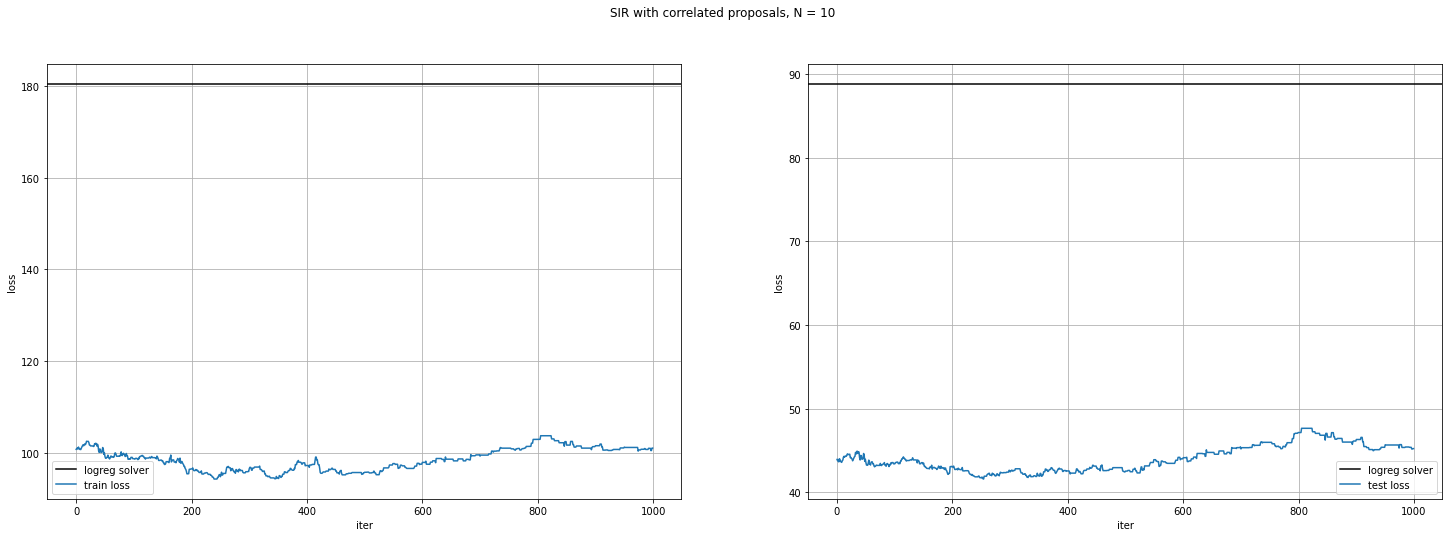

In [336]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [353]:
def sir_independent_dynamics_logreg(z, target, proposal, n_steps, N,
                                    X_train, X_test,
                                    y_train, y_test):
    z_sp = []
    loss_train = []
    loss_test = []
    
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        train_loss = target.func(z, X_train, y_train).item()
        test_loss = target.func(z, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))

    z_sp.append(z)
    return z_sp, loss_train, loss_test

In [354]:
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
n_steps = 1000
batch_size = 1
N = 10
batch_size = 1
start = proposal.sample([batch_size])

In [355]:
history, loss_train, loss_test = sir_independent_dynamics_logreg(start, 
                                                                 target,
                                                                 proposal, 
                                                                 n_steps, 
                                                                 N,
                                                                 X_train, X_test,
                                                                 y_train, y_test)

Iter: 0, Training loss: 99.376076, Test loss 42.993092
Iter: 1, Training loss: 99.972679, Test loss 42.974308
Iter: 2, Training loss: 101.236427, Test loss 43.355640
Iter: 3, Training loss: 101.236427, Test loss 43.355640
Iter: 4, Training loss: 101.236427, Test loss 43.355640
Iter: 5, Training loss: 101.236427, Test loss 43.355640
Iter: 6, Training loss: 101.236427, Test loss 43.355640
Iter: 7, Training loss: 98.308533, Test loss 42.084042
Iter: 8, Training loss: 98.308533, Test loss 42.084042
Iter: 9, Training loss: 98.308533, Test loss 42.084042
Iter: 10, Training loss: 98.308533, Test loss 42.084042
Iter: 11, Training loss: 98.308533, Test loss 42.084042
Iter: 12, Training loss: 98.308533, Test loss 42.084042
Iter: 13, Training loss: 98.308533, Test loss 42.084042
Iter: 14, Training loss: 98.308533, Test loss 42.084042
Iter: 15, Training loss: 98.308533, Test loss 42.084042
Iter: 16, Training loss: 98.308533, Test loss 42.084042
Iter: 17, Training loss: 98.308533, Test loss 42.0840

Iter: 274, Training loss: 101.065987, Test loss 43.688374
Iter: 275, Training loss: 101.065987, Test loss 43.688374
Iter: 276, Training loss: 101.065987, Test loss 43.688374
Iter: 277, Training loss: 101.065987, Test loss 43.688374
Iter: 278, Training loss: 101.065987, Test loss 43.688374
Iter: 279, Training loss: 101.065987, Test loss 43.688374
Iter: 280, Training loss: 101.065987, Test loss 43.688374
Iter: 281, Training loss: 101.065987, Test loss 43.688374
Iter: 282, Training loss: 101.065987, Test loss 43.688374
Iter: 283, Training loss: 101.065987, Test loss 43.688374
Iter: 284, Training loss: 101.065987, Test loss 43.688374
Iter: 285, Training loss: 101.065987, Test loss 43.688374
Iter: 286, Training loss: 101.065987, Test loss 43.688374
Iter: 287, Training loss: 101.065987, Test loss 43.688374
Iter: 288, Training loss: 101.065987, Test loss 43.688374
Iter: 289, Training loss: 101.065987, Test loss 43.688374
Iter: 290, Training loss: 101.065987, Test loss 43.688374
Iter: 291, Tra

Iter: 552, Training loss: 101.065987, Test loss 43.688374
Iter: 553, Training loss: 101.065987, Test loss 43.688374
Iter: 554, Training loss: 101.065987, Test loss 43.688374
Iter: 555, Training loss: 101.065987, Test loss 43.688374
Iter: 556, Training loss: 101.065987, Test loss 43.688374
Iter: 557, Training loss: 101.065987, Test loss 43.688374
Iter: 558, Training loss: 101.065987, Test loss 43.688374
Iter: 559, Training loss: 101.065987, Test loss 43.688374
Iter: 560, Training loss: 101.065987, Test loss 43.688374
Iter: 561, Training loss: 101.065987, Test loss 43.688374
Iter: 562, Training loss: 101.065987, Test loss 43.688374
Iter: 563, Training loss: 101.065987, Test loss 43.688374
Iter: 564, Training loss: 101.065987, Test loss 43.688374
Iter: 565, Training loss: 101.065987, Test loss 43.688374
Iter: 566, Training loss: 101.065987, Test loss 43.688374
Iter: 567, Training loss: 101.065987, Test loss 43.688374
Iter: 568, Training loss: 101.065987, Test loss 43.688374
Iter: 569, Tra

Iter: 832, Training loss: 101.065987, Test loss 43.688374
Iter: 833, Training loss: 101.065987, Test loss 43.688374
Iter: 834, Training loss: 101.065987, Test loss 43.688374
Iter: 835, Training loss: 101.065987, Test loss 43.688374
Iter: 836, Training loss: 101.065987, Test loss 43.688374
Iter: 837, Training loss: 101.065987, Test loss 43.688374
Iter: 838, Training loss: 101.065987, Test loss 43.688374
Iter: 839, Training loss: 101.065987, Test loss 43.688374
Iter: 840, Training loss: 101.065987, Test loss 43.688374
Iter: 841, Training loss: 101.065987, Test loss 43.688374
Iter: 842, Training loss: 101.065987, Test loss 43.688374
Iter: 843, Training loss: 101.065987, Test loss 43.688374
Iter: 844, Training loss: 101.065987, Test loss 43.688374
Iter: 845, Training loss: 101.065987, Test loss 43.688374
Iter: 846, Training loss: 101.065987, Test loss 43.688374
Iter: 847, Training loss: 101.065987, Test loss 43.688374
Iter: 848, Training loss: 101.065987, Test loss 43.688374
Iter: 849, Tra